In [0]:
import numpy as np
import cv2 as cv
import os

In [0]:
width = 0
height = 0
interpolation_obj = None

def simplePreprocessor(w, h, inter=cv.INTER_AREA):
  global width,height,interpolation_obj
  width,height,interpolation_obj = w,h,inter

def preprocess(image):
  return cv.resize(image, (width, height),interpolation=interpolation_obj)

In [0]:
def load(imagePaths, verbose=-1):
  data = []
  labels = []
  for (i,imagePath) in enumerate(imagePaths):
    print(i)
    print(imagePath)
    image = cv.imread(imagePath)
    label = imagePath.split(os.path.sep)[-2]
    image = preprocess(image)
    data.append(image)
    labels.append(label)
    if verbose>0 and i>0 and (i+1)%verbose==0:
      print("[INFO] processed {}/{}".format(i+1,len(imagePaths)))
      print(imagePath)
  return(np.array(data), np.array(labels))

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

In [5]:
print("[INFO] Loading Images...")
imagePaths = list(paths.list_images("/content/drive/My Drive/Data Science/Animals/Extracted/animals"))

simplePreprocessor(32, 32)
(data, labels) = load(imagePaths, verbose=500)

# show some information on memory consumption of the images
print("[INFO] features matrix: {:.1f}MB".format(data.nbytes / (1024 * 1000.0)))

Streaming output truncated to the last 5000 lines.
506
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00306.jpg
507
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00015.jpg
508
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00060.jpg
509
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00585.jpg
510
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00470.jpg
511
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00153.jpg
512
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00221.jpg
513
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00304.jpg
514
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00037.jpg
515
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00607.jpg
516
/content/drive/My Drive/Data Science/Animals/Extracted/animals/cats/cats_00

In [6]:
print(data.shape)
print(labels.shape)
print(np.unique(labels))

(3000, 32, 32, 3)
(3000,)
['cats' 'dogs' 'panda']


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D,Activation,Flatten,Dense

Using TensorFlow backend.


In [0]:
def shallowNet_model(width,height,depth,classes):
  model = Sequential()
  model.add(Conv2D(32,(3,3),padding='same',input_shape=(height,width,depth)))
  model.add(Activation('relu'))
  
  model.add(Flatten())
  model.add(Dense(classes))
  model.add(Activation('softmax'))
  
  return model

In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

In [0]:
data = data.astype('float')/255.0

In [0]:
train_x,test_x,train_y,test_y = train_test_split(data, labels, test_size=0.25, random_state=42)
train_y = LabelBinarizer().fit_transform(train_y)
test_y = LabelBinarizer().fit_transform(test_y)

In [25]:
print("[INFO] compiling model...")
opti = SGD(lr=0.005)
model = shallowNet_model(32,32,3,3)
model.compile(loss="categorical_crossentropy", optimizer=opti, metrics=['accuracy'])

print("[INFO] Training the Network...")
H = model.fit(train_x, train_y, validation_data=(test_x,test_y), batch_size=32, epochs=100 ,verbose=1)

[INFO] compiling model...
[INFO] Training the Network...
Train on 2250 samples, validate on 750 samples
Epoch 1/100
2250/2250 [==============================] - 2s 732us/step - loss: 1.0287 - accuracy: 0.4453 - val_loss: 1.0124 - val_accuracy: 0.5320
Epoch 2/100
2250/2250 [==============================] - 2s 709us/step - loss: 0.9264 - accuracy: 0.5440 - val_loss: 0.9307 - val_accuracy: 0.5253
Epoch 3/100
2250/2250 [==============================] - 2s 705us/step - loss: 0.8915 - accuracy: 0.5453 - val_loss: 0.9654 - val_accuracy: 0.4787
Epoch 4/100
2250/2250 [==============================] - 2s 709us/step - loss: 0.8539 - accuracy: 0.5747 - val_loss: 0.9160 - val_accuracy: 0.5267
Epoch 5/100
2250/2250 [==============================] - 2s 706us/step - loss: 0.8449 - accuracy: 0.5733 - val_loss: 1.0017 - val_accuracy: 0.4613
Epoch 6/100
2250/2250 [==============================] - 2s 705us/step - loss: 0.8244 - accuracy: 0.6036 - val_loss: 0.9354 - val_accuracy: 0.5200
Epoch 7/100
22

In [26]:
print("[INFO] evaulating network...")
predictions = model.predict(test_x,batch_size=32)
print(classification_report(test_y.argmax(axis=1),predictions.argmax(axis=1),target_names=["cat","dog","panda"]))

[INFO] evaulating network...
              precision    recall  f1-score   support

         cat       0.64      0.62      0.63       262
         dog       0.58      0.58      0.58       249
       panda       0.83      0.86      0.84       239

    accuracy                           0.68       750
   macro avg       0.68      0.69      0.69       750
weighted avg       0.68      0.68      0.68       750



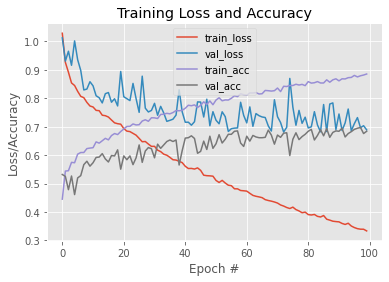

In [27]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**Conclusion:**
# Model is overfitting as the training & validation loss are diverging largely beyong 40th epoch.
# Also the training accuracy is increasing drastically compared to validation accuracy.